In [29]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [30]:
df = pd.read_csv('./Admission_Predict.csv', index_col=False)

In [31]:
#Normalize data using rescale data
for i in df.columns[:-2]:
   df[i] = (df[i] - np.min(df[i])) / (np.max(df[i]) - np.min(df[i]))

#Normalize data using zscore method
#for i in df.columns[:-2]:
#    df[i] = (df[i] - np.mean(df[i])) / np.sqrt(np.sum((df[i] - np.mean(df[i])) ** 2))

In [32]:
#Suffle and split the data to 2 parts: tranning set and test set

#Add bias column to the dataframe
bias = pd.Series(np.ones(len(df)), dtype=np.float64, name='bias')
df = pd.concat([bias, df], axis=1, join='inner')
del df[df.columns[0]]

#Suffle the dataframe
df = df.sample(frac=1, random_state=7)

In [33]:
#Split train, test set
train_num = int(len(df) * 3 / 4) 
X_train = df[:train_num].values[:, :-1]
Y_train = df[:train_num].values[:, -1].reshape(-1, 1)

X_test = df[train_num:].values[:, :-1]
Y_test = df[train_num:].values[:, -1].reshape(-1, 1)

In [34]:
class Linear_regression:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
    
    def loss_function(self, w):
        return np.sum((self.X_train.dot(w)
                       - self.Y_train) ** 2 
                        / (2 * len(self.X_train))
                     )
    
    def grad(self, w, batch):
        X_batch = self.X_train[batch[0] : batch[1]]
        Y_batch = self.Y_train[batch[0] : batch[1]]
        return X_batch.T.dot(X_batch.dot(w) - Y_batch) / (batch[1] - batch[0])
                                    
    def fit_batch_gd(self, initialize, leaning_rate, threhold, batch_size, max_loop=5000):
        w = np.array(initialize).reshape(-1, 1)
        epoch = 0
        cost = []
        len_interval = int(len(X_train) / batch_size)
        while np.sum(np.abs(self.grad(w, [0 , len(self.X_train)]))) > threhold:
            cost.append(self.loss_function(w))
            l_index = random.randint(0, len_interval - 1) * batch_size
            h_index = l_index + batch_size
            w = w - leaning_rate * self.grad(w, [l_index, h_index])
            epoch += 1
            if epoch > max_loop:
                break
        return w, epoch, cost        
    
    def fit_nag(self, initialize, learning_rate, gamma, threhold, batch_size, max_loop=5000):
        w = np.array(initialize).reshape(-1, 1)
        v = np.zeros(len(w)).reshape(-1, 1)
        epoch = 0
        cost = []
        len_interval = int(len(X_train) / batch_size)
        while np.sum(np.abs(self.grad(w, [0, len(self.X_train)]))) > threhold:
            cost.append(self.loss_function(w))
            l_index = random.randint(0, len_interval - 1) * batch_size
            h_index = l_index + batch_size
            v = gamma * v + learning_rate * self.grad(w - gamma * v, [l_index, h_index])
            w -= v
            epoch += 1
            if epoch > max_loop:
                break
        return w, epoch, cost
    
    def fit_momentum(self, initialize, learning_rate, gamma, threhold, batch_size, max_loop=5000):
        w = np.array(initialize).reshape(-1, 1)
        v = np.zeros(len(w)).reshape(-1, 1)
        epoch = 0
        cost = []
        len_interval = int(len(X_train) / batch_size)
        while np.sum(np.abs(self.grad(w, [0, len(self.X_train)]))) > threhold:
            cost.append(self.loss_function(w))
            l_index = random.randint(0, len_interval - 1) * batch_size
            h_index = l_index + batch_size
            v = gamma * v + learning_rate * self.grad(w, [l_index, h_index])
            w -= v
            epoch += 1
            if epoch > max_loop:
                break
        return w, epoch, cost
    
    def fit_RMSprop(self, initialize, learning_rate, gamma, threhold, batch_size, max_loop=5000):
        w = np.array(initialize).reshape(-1, 1)
        E = np.zeros(len(w)).reshape(-1, 1)
        epoch = 0
        cost = []
        len_interval = int(len(X_train) / batch_size)
        while np.sum(np.abs(self.grad(w, [0, len(self.X_train)]))) > threhold:
            cost.append(self.loss_function(w))
            l_index = random.randint(0, len_interval - 1) * batch_size
            h_index = l_index + batch_size
            E = gamma * E + (1 - gamma) * grad(w, [l_index, h_index]) ** 2
            w -= learning_rate / np.sqrt(E + epsilon) * grad(w, [l_index, h_index])
            epoch += 1
            if epoch > max_loop:
                break
        return w, epoch, cost

In [35]:
#Initialize model
w = np.zeros(len(X_train[0]))
learning_rate = 0.06
threhold = 1e-10
gamma = 0.9

lin = Linear_regression(X_train, Y_train, X_test, Y_test)

In [36]:
#Variant of gradient descent
w_bgd, loop_bgd, cost_bgd = lin.fit_batch_gd(w, learning_rate, threhold, len(X_train))
w_sgd, loop_sgd, cost_sgd = lin.fit_batch_gd(w, learning_rate, threhold, 1)
w_mnb, loop_mnb, cost_mnb = lin.fit_batch_gd(w, learning_rate, threhold, 20)

In [37]:
#Test by using the psedo-inverse matrix
print("Using batch gradient descent: \n\t w = ", w_mnb[:, 0])

w1 = np.linalg.pinv(X_train).dot(Y_train)
np.linalg.norm(w1 - w_mnb) / len(w_mnb)
print("Using psedo-inverse matrix: \n\t w = ", w1[:, 0])

from sklearn import linear_model
a = linear_model.LinearRegression()
a.fit(X_train, Y_train)
print("Using sklearn: \n\t w = ", a.coef_[0, :])

Using batch gradient descent: 
	 w =  [ 0.18967884  0.08475521  0.19554051 -0.04867199  0.05902694  0.24067918
  0.51641837 -0.00495383]
Using psedo-inverse matrix: 
	 w =  [ 0.18505741  0.05207351  0.17953787 -0.05004692  0.04987949  0.23110834
  0.58130704  0.00708695]
Using sklearn: 
	 w =  [0.05530966 0.0782389  0.09247014 0.02388274 0.0023451  0.08464508
 0.35923546 0.02562982]


In [38]:
# Evaluate linear regression when using Batch Gradient Descent
RAS = np.sum(np.abs(X_test.dot(w_bgd) - Y_test)) / len(X_test)
RMS = np.sum((X_test.dot(w_bgd) - Y_test) ** 2) / len(X_test)
VarTest = np.sum((Y_test - np.mean(Y_test)) ** 2) / len(X_test)
R2 =  1 - RMS / VarTest

R2, RAS, RMS

(0.6650678445436572, 0.06345618439130767, 0.006594850983472491)

In [39]:
# Evaluate linear regression when using Minibatch
RAS = np.sum(np.abs(X_test.dot(w_mnb) - Y_test)) / len(X_test)
RMS = np.sum((X_test.dot(w_mnb) - Y_test) ** 2) / len(X_test)
VarTest = np.sum((Y_test - np.mean(Y_test)) ** 2) / len(X_test)
R2 =  1 - RMS / VarTest

R2, RAS, RMS

(0.6682263893114782, 0.06310510041813865, 0.006532658889554173)

In [40]:
# Evaluate linear regression when using SGD
RAS = np.sum(np.abs(X_test.dot(w_sgd) - Y_test)) / len(X_test)
RMS = np.sum((X_test.dot(w_sgd) - Y_test) ** 2) / len(X_test)
VarTest = np.sum((Y_test - np.mean(Y_test)) ** 2) / len(X_test)
R2 =  1 - RMS / VarTest

R2, RAS, RMS

(0.6030695151100447, 0.06837581373455918, 0.00781560490983656)

<IPython.core.display.Javascript object>


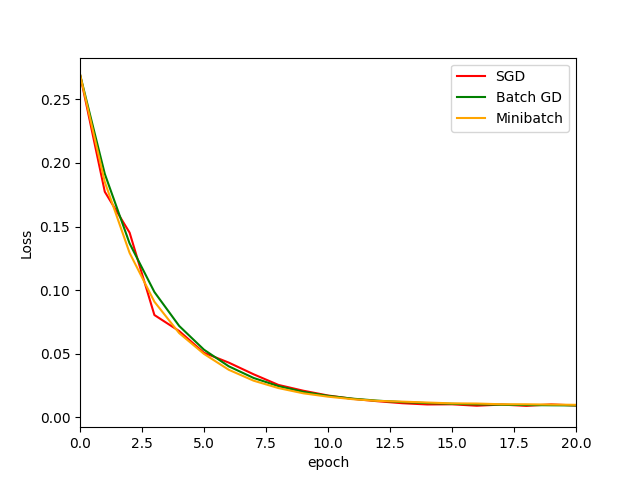

In [41]:
fig, ax = plt.subplots()
ax.plot(cost_sgd, label='SGD', color='r')
ax.plot(cost_bgd, label='Batch GD', color='g')
ax.plot(cost_mnb, label='Minibatch', color='orange')
ax.set_xlim(0, 20)
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.legend()

<IPython.core.display.Javascript object>


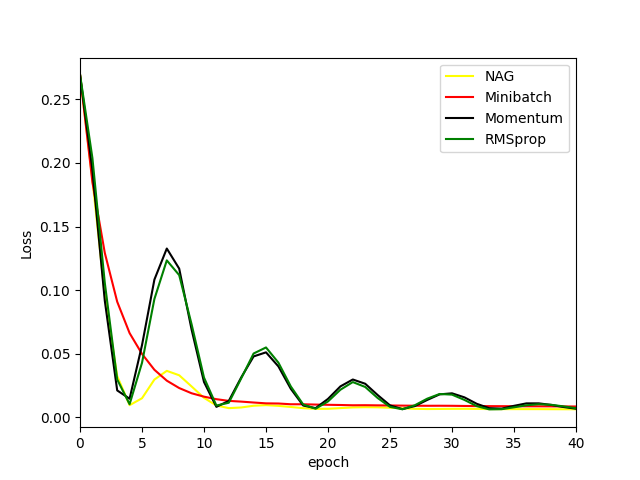

Text(0, 0.5, 'Loss')

In [42]:
gamma = 0.9
#Use other methods
w_nag, loop_nag, cost_nag = lin.fit_nag(w, learning_rate, gamma, threhold, 20)
w_mmt, loop_mmt, cost_mmt = lin.fit_momentum(w, learning_rate, gamma, threhold, 20)
w_rms, loop_rms, cost_rms = lin.fit_momentum(w, learning_rate, gamma, threhold, 20)

#Plot
fig, ax = plt.subplots()
ax.plot(cost_nag, label='NAG', color='yellow')
ax.plot(cost_mnb, label='Minibatch', color='red')
ax.plot(cost_mmt, label='Momentum', color='black')
ax.plot(cost_rms, label='RMSprop', color='green')
ax.set_xlim(0, 40)
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')